In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
from math import ceil, floor
from datetime import datetime 
torch.manual_seed(123)
from tqdm import tqdm
import numpy as np
import random
from torchvision.utils import draw_bounding_boxes
import itertools

### Model 1 - CNN with one fc layer at the end

In [3]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

class CNN_1(nn.Module):
    def __init__(self, in_channels = 1, out_channels = 15): #out_channel [p, x, y, w, h, c_0, ..., c_10] = 15
        super().__init__()
        # image dimension: 48x60

        self.conv1 = nn.Conv2d(in_channels, 4, kernel_size=3, stride=1, padding=1) #size: 48x60
        self.conv2 = nn.Conv2d(4, 8, kernel_size=3, stride=1, padding=1) #size: 48x60
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2) #size: 24x30
        self.conv3 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1) #size: 24x30
        self.conv4 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1) #size: 24x30
        # max_pool, size: 12x15
        self.conv5 = nn.Conv2d(32, 16, kernel_size=(3,2), stride=1, padding=1) #size: 12x16
        # max_pool, size: 6x8
        self.conv6 = nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1) #size: 6x8
        # max_pool, size: 3x4
        self.conv7 = nn.Conv2d(8, 4, kernel_size=3, stride=1, padding=1) #size: 3x4

        # fully connected layer at the end ?
        self.fc = nn.Linear(4*3*4, out_channels) #48x15

    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(out)
        out = self.conv2(out)
        out = F.relu(out)
        out = self.max_pool(out)
        out = self.conv3(out)
        out = F.relu(out)
        out = self.conv4(out)
        out = F.relu(out)
        out = self.max_pool(out)
        out = self.conv5(out)
        out = F.relu(out)
        out = self.max_pool(out)
        out = self.conv6(out)
        out = F.relu(out)
        out = self.max_pool(out)
        out = self.conv7(out)
        out = F.relu(out)

        out = out.view(-1, out.shape[-3]*out.shape[-2]*out.shape[-1]) #flatten the dimensions to fit the fully connected layer
        out = self.fc(out)
        return out

Training on device cpu.


### Model 2 - Only convolutional layers 

In [4]:
class MyConvOnlyCNN(nn.Module):
    def __init__(self):
        super(MyConvOnlyCNN, self).__init__()
        self.features = nn.Sequential(
            # Input: (batch_size, 1, 48, 60)
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # -> (batch_size, 32, 48, 60)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),        # -> (batch_size, 32, 24, 30)
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # -> (batch_size, 64, 24, 30)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),        # -> (batch_size, 64, 12, 15)
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1), # -> (batch_size, 128, 12, 15)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)         # -> (batch_size, 128, 6, 7)
        )
        
        # Final convolution with a kernel that spans the entire spatial size (6x7)
        # This produces an output of shape (batch_size, 15, 1, 1)
        self.conv_out = nn.Conv2d(128, 15, kernel_size=(6, 7))
    
    def forward(self, x):
        x = self.features(x)
        x = self.conv_out(x)
        x = x.view(x.size(0), -1)  # Flatten to shape (batch_size, 15)
        return x

### Model 3 - Residual network

In [5]:
class ResidualBlock(nn.Module):
    """
    A single residual block with two Conv-BN-ReLU sequences
    and a skip connection: output = ReLU( x + F(x) ).
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
        super(ResidualBlock, self).__init__()
        
        padding = kernel_size // 2 # ensures height/witdh remains the same when stride = 1

        self.conv1 = nn.Conv2d(in_channels, out_channels, 
                               kernel_size=kernel_size, 
                               stride=stride, 
                               padding=padding, 
                               bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, 
                               kernel_size=kernel_size, 
                               stride=1, 
                               padding=padding, 
                               bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # needed if input and output have different shapes 
        # applying a 1 x 1 convolution reshapes the input to the correct dimension
        self.shortcut = nn.Sequential()
        if (stride != 1) or (in_channels != out_channels):
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 
                          kernel_size=1, 
                          stride=stride, 
                          bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        # saves original input x
        identity = x 

        # First convolution
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        
        # Second convolution
        out = self.conv2(out)
        out = self.bn2(out)
        
        # Applies the shortcut if needed
        identity = self.shortcut(identity)
        
        # Add skip connection
        out += identity
        out = F.relu(out)
        
        return out

class SimpleResNet(nn.Module):
    def __init__(self, out_channels=15):
        """
        ResNet-like model that ends with a final output of dimension 15.
        """
        super().__init__()

        # Stage 1: 1 -> 4 -> 8 channels, then pool
        self.block1 = ResidualBlock(1, 4)
        self.block2 = ResidualBlock(4, 8)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # 48×60 -> 24×30

        # Stage 2: 8 -> 16 -> 32, then pool
        self.block3 = ResidualBlock(8, 16)
        self.block4 = ResidualBlock(16, 32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # 24×30 -> 12×15

        # Stage 3: conv (3,2) from 32 -> 16, then pool
        # (replicates conv5 in your original network)
        self.conv5 = nn.Conv2d(32, 16, kernel_size=(3,2), 
                               stride=1, padding=(1,1), 
                               bias=False)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # 12×?? -> 6×8

        # Stage 4: 16 -> 8, then pool
        self.block5 = ResidualBlock(16, 8)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)  # 6×8 -> 3×4

        # Final block: 8 -> 4
        self.block6 = ResidualBlock(8, 4)

        # FC: flatten from [batch_size, 4, 3, 4] -> 48, then output 15
        self.fc = nn.Linear(4 * 3 * 4, out_channels)

    def forward(self, x):
        # Stage 1
        out = self.block1(x)
        out = self.block2(out)
        out = self.pool1(out)

        # Stage 2
        out = self.block3(out)
        out = self.block4(out)
        out = self.pool2(out)

        # Stage 3
        out = self.conv5(out)
        out = F.relu(out)
        out = self.pool3(out)

        # Stage 4
        out = self.block5(out)
        out = self.pool4(out)

        # Final block
        out = self.block6(out)

        # Flatten to [batch_size, 48], then FC -> 15
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

## Localization loss function


In [6]:
def localization_loss(y_pred, y_true):
    """
    Calculates the detection loss, localization loss and classification loss.
    Returns a total loss
    """
    # Detection loss
    L_A = nn.BCEWithLogitsLoss()
    # Bounding box loss (localization loss)
    L_B = nn.MSELoss()
    # Classification loss
    L_C = nn.CrossEntropyLoss()

    # er dette nødvendig egentlig ?? Se om crossentropy loss regnes riktig uten å endre på y_true
    # change format of y_true from [p, x, y, w, h, c] to [p, x, y, w, h, c_1, ..., c_10]
    #c = y_true[:, 5].long()  # get the class index
    #y_true_one_hot = torch.zeros(y_true.size(0), 10, device=y_true.device)  # create a zero tensor for one-hot encoding, device = device ?
    #y_true_one_hot.scatter_(1, c.unsqueeze(1), 1)  # set the corresponding class index to 1
    #y_true = torch.cat([y_true[:, :5], y_true_one_hot], dim=1)  # concatenate the one-hot encoded classes with the rest of y_true

    
    return torch.where(
        # if there is an object; calculate input
        condition=y_true[:, 0].bool(), 

        # L = L_A + L_B + L_C, when object is detected
        input= L_A(y_pred[:, :1], y_true[:, :1]) + 
        L_B(y_pred[:, 1:5], y_true[:, 1:5]) + 
        L_C(y_pred[:, 5:], y_true[:, 5].long()),

        # L = L_A, when object is not detected
        other= L_A(y_pred[:, :1], y_true[:, :1])
    ).mean()




### Load data and preprocessing

/var/folders/6t/376dzz3552sbcyyx1b7h7yfm0000gn/T/ipykernel_1037/286593349.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_train = torch.load(path + "train.pt")
/var

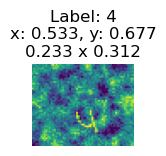

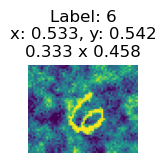

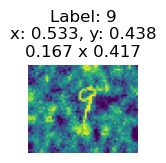

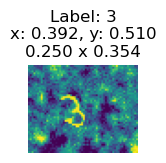

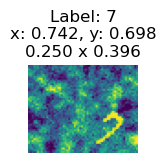

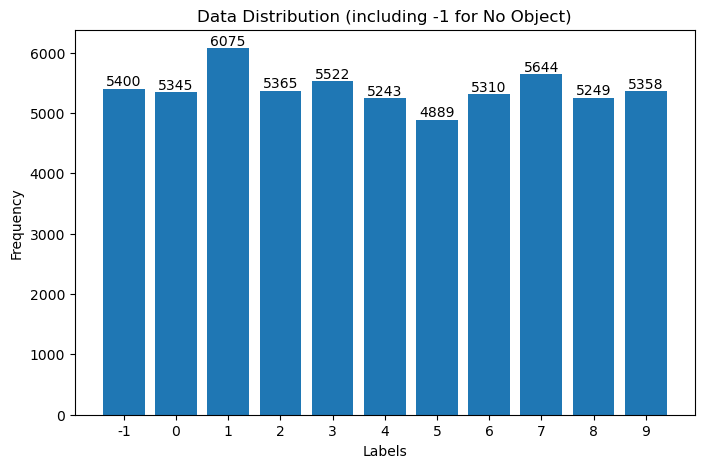

{-1.0: 5400,
 0.0: 5345,
 1.0: 6075,
 2.0: 5365,
 3.0: 5522,
 4.0: 5243,
 5.0: 4889,
 6.0: 5310,
 7.0: 5644,
 8.0: 5249,
 9.0: 5358}

In [3]:
def load_data(path="data/localization_"):
    """
    Load data from path, return train, val, test
    """
    data_train = torch.load(path + "train.pt")
    data_val = torch.load(path + "val.pt")
    data_test = torch.load(path + "test.pt")


    return data_train, data_val, data_test


import numpy as np
import matplotlib.pyplot as plt

def data_distribution(data):
    """
    Plots the distribution of the given data across the labels,
    including a -1 label when there is no object in an image.
    """
    # Map p_c=1 -> label[5], p_c=0 -> -1
    all_labels = []
    for _, label in data:
        pc = label[0]
        class_label = label[5]
        
        if pc == 1:
            all_labels.append(class_label)
        else:
            # Use -1 if there is no object
            all_labels.append(-1)

    # Calculate distribution
    unique_labels, counts = np.unique(all_labels, return_counts=True)
    distribution = dict(zip(unique_labels, counts))
    
    # Convert label values to strings for plotting
    x_labels = [str(int(lbl)) for lbl in unique_labels]

    # Visualize the label distribution
    plt.figure(figsize=(8, 5))
    bars = plt.bar(x_labels, counts)
    
    # Add counts above each bar
    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width()/2,
                 bar.get_height() + 0.5, 
                 str(count), 
                 ha='center', va='bottom', fontsize=10)

    plt.xlabel('Labels')
    plt.ylabel('Frequency')
    plt.title('Data Distribution (including -1 for No Object)')
    plt.show()
    
    return distribution



def visualize_random_images(data, num_images):
    """
    Visualizes random images from the data
    """
    indices = random.sample(range(len(data)), num_images)
    samples = [data[i] for i in indices]
    # Set up the figure
    plt.figure(figsize=(6, 4))
    
    # Loop over the selected samples
    for i, (img, label) in enumerate(samples):
        digit = int(label[5])
        x, y, w, h = label[1], label[2], label[3], label[4]
        

        plt.subplot(1, num_images, i+1)
        
        # If the image is a tensor, convert it to a numpy array for plotting.
        if torch.is_tensor(img):
            # Convert from (C, H, W) to (H, W, C)
            img = img.permute(1, 2, 0).numpy()
            
        plt.imshow(img)
        title_str = f"Label: {digit}\nx: {x:.3f}, y: {y:.3f}\n{w:.3f} x {h:.3f}"
        plt.title(title_str)
        plt.axis('off')
    
        plt.tight_layout()
        plt.show()

train_data, val_data, test_data = load_data()

visualize_random_images(train_data, 5)
data_distribution(train_data)

### Normalize Images

In [8]:

def mean_std(data):
    """
    Calculate the mean and standard deviation of the data.
    """
    img, _ = data.tensors
    img = img.float()
    mean = img.mean(dim=(0, 2, 3))
    std = img.std(dim=(0, 2, 3))

    return mean, std

class LocalizationDataset(Dataset):
    """
    A dataset class representing the 
    data and for applying normalization
    """
    def __init__(self, data, preprocessor=None):
        self.data = data
        self.preprocessor = preprocessor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image, label = self.data[index]
        
        if self.preprocessor:
            image = self.preprocessor(image)
            
        return image, label
    
mean, std = mean_std(train_data)
print(f"Mean: {mean}")
print(f"Std: {std}")

preprocessor = transforms.Compose([
        transforms.Normalize(mean, std)
])

# preprocesses data
train_data = LocalizationDataset(train_data, preprocessor = preprocessor)
val_data = LocalizationDataset(val_data, preprocessor = preprocessor)
test_data = LocalizationDataset(test_data, preprocessor = preprocessor)


Mean: tensor([0.4171])
Std: tensor([0.2138])


### Training

In [9]:
def train(n_epochs, optimizer, model, loss_func, train_loader):
    """
    A training function for training the models 
    and returning the losses
    """
    
    n_batch = len(train_loader)
    losses_train = []
    model.train()
    optimizer.zero_grad(set_to_none=True)
    
    
    for epoch in range(1, n_epochs + 1):
        
        loss_train = 0.0
        for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{n_epochs}", leave=False):

            imgs = imgs.to(device=device, dtype=torch.double) 
            labels = labels.to(device=device, dtype=torch.double)

            outputs = model(imgs)
            
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_train += loss.item()
            
        losses_train.append(loss_train / n_batch)
        
        print('{}  |  Epoch {}  |  Training loss {:.5f}'.format(
            datetime.now().time(), epoch, loss_train / n_batch))
        
    return losses_train 

##### For testing the training loop, can be deleted later

In [51]:
#model = CNN_1(in_channels=1).to(device=device, dtype=torch.double)
#optimizer = optim.Adam(model.parameters(), lr=0.001)
#train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
#loss_func = localization_loss

#train(1, optimizer, model, loss_func, train_loader)

### Visualizing Predictions

In [10]:
def unnormalize(image, mean, std):
    """
    A function for unnormalizing the data
    before visualizing predctions
    """
    return image * std + mean

def convert_box(box, H, W):
    """
    A function for converting box 
    coordinates in right format for visualizing
    """
    x, y, w, h = box
    x_min = (x - w / 2) * W
    y_min = (y - h / 2) * H
    x_max = (x + w / 2) * W
    y_max = (y + h / 2) * H
    return torch.tensor([x_min, y_min, x_max, y_max], device=box.device)


def visualize_predictions(model, image, label, preprocessor=None, mean=[0.0], std=[1.0], detection_threshold=0.5):
    """
    Visualizes predictions of images 
    by showing truth bounding box, predicted bounding box,
    predicted label (with probability) and true label
    """
    model.eval()
    device = next(model.parameters()).device

    image_proc = preprocessor(image) if preprocessor else image.clone()
    image_proc = image_proc.unsqueeze(0).to(device, dtype = torch.double)

    with torch.no_grad():
        outputs = model(image_proc)

    pred = outputs[0]
    pred_pc = torch.sigmoid(pred[0]).item()
    pred_box = pred[1:5]
    pred_class = torch.argmax(pred[5:]).item()

    gt_pc = label[0].item()
    gt_box = label[1:5]
    gt_class = int(label[5].item())

    image_disp = unnormalize(image, mean, std)
    image_disp = (image_disp.clamp(0, 1) * 255).to(torch.uint8)
    if image_disp.shape[0] == 1:
        image_disp = image_disp.repeat(3, 1, 1)
    _, H, W = image_disp.shape

    pred_box_pixels = convert_box(pred_box, H, W)
    gt_box_pixels = convert_box(gt_box, H, W)

    boxes = []
    colors = []
    
    if pred_pc > detection_threshold:
        boxes.append(pred_box_pixels)
        colors.append("red")
    
    if gt_pc > 0.5:
        boxes.append(gt_box_pixels)
        colors.append("green")
        
    if boxes:
        boxes = torch.stack(boxes)
        image_with_boxes = draw_bounding_boxes(image_disp, boxes, colors=colors, width=1)
    else:
        image_with_boxes = image_disp

    image_np = image_with_boxes.permute(1, 2, 0).cpu().numpy()

    plt.figure(figsize=(6, 6))
    plt.imshow(image_np)
    plt.axis("off")
    plt.title("Prediction vs Ground Truth")
    caption = (f"Prediction: Class {pred_class} (Prob: {pred_pc:.2f}) | "
               f"Ground Truth: Class {gt_class}")
    plt.figtext(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=12)
    plt.show()

### Model selection and evaluation

In [11]:
def _change_coordinates(bb):
    """
    Change bb from [x, y, w, h] to [x1, y1, x2, y2] (topleft and downright corners)
    """
    x1 = bb[0] - bb[2]/2 # midt - bredde
    y1 = bb[1] - bb[3]/2 # midt - høyde

    x2 = bb[0] + bb[2]/2 # midt + bredde
    y2 = bb[1] + bb[3]/2 # midt + høyde

    return [x1, y1, x2, y2]


In [12]:
def intersection(bb1, bb2):
    """
    Compute intersection between 2 bb, in global frame of ref
    """
    
    # Change bb from [x, y, w, h] to [x1, y1, x2, y2] (topleft and downright corners)
    b1 = _change_coordinates(bb1)
    b2 = _change_coordinates(bb2)

    # når man har formen [x1, y1, x2, y2]:
    xA = max(b1[0], b2[0]) # finner største x verdi for topleft corner
    yA = max(b1[1], b2[1]) # finner største y verdi for topleft corner
    # (xA, yA) er topleft av intersection 
    
    xB = min(b1[2], b2[2]) # finner minste x verdi for downright corner
    yB = min(b1[3], b2[3]) # finner minste y verdi for downright corner
    # (xB, yB) er downright av intersection 

    area = max(xB-xA, 0) * max(yB-yA, 0)
    return area

   
def IoU(bb1, bb2):
    """
    Compute IoU given 2 bb (local or global)
    """
    intersect = intersection(bb1, bb2)
    union = bb1[-1]*bb1[-2] + bb2[-1]*bb2[-2] - intersect
    IoU = intersect / union
    return IoU
   
def compute_IoU_localization(model, loader, preprocessor):
    """
    Computes IoU performance of the model on the given dataset
    """
    model.eval()
    total_iou = 0
    num_samples = 0

    with torch.no_grad():
        for images, labels in loader:
            if preprocessor:
                images = preprocessor(images)
            
            images = images.to(device, dtype=torch.double)
            labels = labels.to(device, dtype=torch.double)

            outputs = model(images)

            mask = (labels[:, 0] == 1)
            if mask.sum() == 0:
                continue

            pred_boxes = outputs[mask, 1:5]
            true_boxes = labels[mask, 1:5]

            batch_iou = []
            for i in range(len(true_boxes)):
                iou_value = IoU(pred_boxes[i], true_boxes[i])
                batch_iou.append(iou_value)
            
            total_iou += sum(batch_iou)
            num_samples += len(images)
            
    return total_iou/num_samples
    
def compute_accuracy_localization(model, loader, preprocessor):
    """
    Compute accuracy of the model on the given dataset
    """
    model.eval()
    num_correct = 0
    num_samples = 0
        
    with torch.no_grad():
        for images, labels in loader:
            if preprocessor:
                images = preprocessor(images)
            
            images = images.to(device,dtype=torch.double)
            labels = labels.to(device, dtype=torch.double)

            outputs = model(images)
            mask = (labels[:, 0] == 1)
            if mask.sum() == 0:
                continue
            class_probs = torch.softmax(outputs[mask, 5:], dim=1)
            class_pred = torch.argmax(class_probs, dim=1)
            class_true = labels[mask, 5].long()

            num_correct += (class_pred == class_true).sum().item()
            num_samples += mask.sum().item()
    
    return num_correct/num_samples
    
def overall_performance(model, loader, preprocessor):
    """
    Compute the overall performance of the model on the given dataset"
    """
    accuracy = compute_accuracy_localization(model, loader, preprocessor)
    IoU = compute_IoU_localization(model, loader, preprocessor)

    print(f"Val Accuracy: {accuracy:.4f}")
    print(f"Val Mean IoU: {IoU:.4f}")
    
    return (accuracy + IoU) / 2

In [13]:
# testing stuff
#val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
#model.eval()

#performance = overall_performance(model, val_loader, preprocessor)
#print(f"Overall performance: {performance:.4f}")

# Sample usage:
#sample_image, sample_label = val_data[7]
#visualize_predictions(model, sample_image, sample_label, preprocessor, mean, std) #mean=[mean.item()], std=[std.item()])

## Model selection of the different models

In [14]:
# Standard hyperparameters for architecture selection
default_lr = 0.001
default_weight_decay = 0.01
batch_size = 64

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
loss_func = localization_loss
# List of model classes to test
models = [SimpleResNet, CNN_1, MyConvOnlyCNN]  # You can add more models here, e.g., [MyCNN, MyConvOnlyCNN]

# Phase 1: Architecture Selection with default hyperparameters
best_model_arch = None
best_arch_score = -float('inf')
all_losses = {}

for model_class in models:
    print(f"Training {model_class.__name__} with default hyperparameters (lr={default_lr}, weight_decay={default_weight_decay})")
    # Instantiate the model
    model = model_class()
    model = model_class().to(device=device, dtype=torch.double)

    
    # Create an optimizer using default hyperparameters
    optimizer = optim.Adam(model.parameters(), lr=default_lr, weight_decay=default_weight_decay)
    
    # Train the model (for a fixed number of epochs, e.g., 1 for quick comparison)
    losses = train(
        n_epochs=100,
        optimizer=optimizer,
        model=model,
        loss_func=loss_func,
        train_loader=train_loader
    )
    
    # Stores the losses 
    all_losses[model_class.__name__] = losses
    
    # Evaluate the model on the validation set
    performance = overall_performance(model, val_loader, preprocessor)
    print(f"Performance for {model_class.__name__}: {performance:.4f}")
    
    # Keep track of the best performing architecture
    if performance > best_arch_score:
        best_arch_score = performance
        best_model_arch = model_class

print("Best model architecture:", best_model_arch.__name__)


Training SimpleResNet with default hyperparameters (lr=0.001, weight_decay=0.01)


KeyboardInterrupt: 

# Testing visualizing

In [ ]:
# Sample usage:
#sample_image, sample_label = val_data[7]
#visualize_predictions(model, sample_image, sample_label, preprocessor, mean, std) #mean=[mean.item()], std=[std.item()])

# Tuning the best performing model

In [15]:

# Define the hyperparameters to search over for tuning
learning_rates = [0.001, 0.0005, 0.0001]
weight_decays = [0, 0.01, 0.001]
# Hyperparameters to add???
# batch size
# optimizer
# momentum 
# IoU threshold


# Phase 2: Hyperparameter Tuning for the best architecture
best_model = None
best_score = -float('inf')
best_hyperparams = {}

for lr, wd in itertools.product(learning_rates, weight_decays):
    print(f"Tuning {best_model_arch.__name__} with lr={lr}, weight_decay={wd}:")
    
    # Instantiate a new model for each hyperparameter combination
    model = best_model_arch()
    model = model_class().to(device=device, dtype=torch.double)

    # Create an optimizer with current hyperparameters
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    
    # Train the model on the training data
    losses = train(
        n_epochs=1,
        optimizer=optimizer,
        model=model,
        loss_func=loss_func,
        train_loader=train_loader
    )
    
    # Evaluate the model on the validation data
    performance = overall_performance(model, val_loader, preprocessor)
    print(f"Overall performance: {performance:.4f}\n")
    
    # Update the best model if performance improves
    if performance > best_score:
        best_score = performance
        best_model = model
        best_hyperparams = {
            'model': best_model_arch.__name__,
            'lr': lr,
            'weight_decay': wd
        }

print("Best hyperparameters:", best_hyperparams)
print("Best overall performance on validation set:", best_score)


AttributeError: 'NoneType' object has no attribute '__name__'

### Evaluating best model witb tuned hyperparmeters on test set

In [ ]:
test_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_overall_performance = overall_performance(best_model, test_loader, preprocessor)
print(f"Test overall performance: {test_overall_performance:.4f}")

1) CNN_1
Architecture Overview
* Layer sequence:
    1. Convolution layers (1 → 4 → 8 → 16 → 32 → 16 → 8 → 4) interspersed with
    2. MaxPool layers after every couple of convolutions.
    3. A final fully connected layer from a flattened 4×3×4 = 48 features to 15 outputs.
Notable Points
1. Progressive channel changes:
    * Channels go up to 32, then back down to 16, 8, 4. This oscillation can help reduce parameter count and computational load toward the end, but sometimes it may be more typical to keep increasing or at least maintain channel depth in later layers. Nonetheless, for a small-scale task, this can be perfectly fine, especially if you want to end up with a small feature map for the final FC layer.
2. Multiple pooling steps:
    * With four max-pool operations, the spatial dimensions drastically reduce from (48×60) to (3×4). This ensures a strong reduction in feature map size, making your final FC layer very lightweight. However, repeated pooling can sometimes remove fine-grained spatial information—depending on your data, you may or may not need that. If high localization accuracy is needed, fewer pool layers (or smaller strides) might preserve more spatial detail.
3. Kernel sizes:
    * Mostly 3×3, except for a (3×2) kernel in conv5. This might be due to the specific data dimensions you have (48×60). It’s a creative choice—just ensure it suits your dataset shape and the aspect ratio of features you’re detecting.
4. No batch normalization:
    * There is no BatchNorm, which is typical in many modern architectures. You could consider adding BatchNorm or LayerNorm for potentially more stable training, but this depends on your dataset’s variability and batch sizes.
5. Overall usage:
    * This architecture is straightforward to implement and often easy to debug. It’s good for smaller image sizes or simpler tasks.

2) MyConvOnlyCNN
Architecture Overview
1. Feature Extractor: A sequence of three convolution blocks (Conv → ReLU → MaxPool) going from 1 → 32 → 64 → 128 channels, reducing the spatial dimension from 48×60 to 6×7.
2. Global-like convolution: A final Conv2d(128, 15, kernel_size=(6,7)) that spans the entire remaining spatial dimension, effectively acting like a global pooling plus a linear transform in a single step.
3. The output is then reshaped to (batch_size, 15).
Notable Points
1. Simplicity:
    * This is a compact approach: you use successively deeper conv layers with typical doubling of channels (32 → 64 → 128), then a single kernel that “collapses” the final feature map to 1×1. It’s reminiscent of global average pooling or global max pooling (but done via a full-spatial conv).
2. Channel scaling:
    * The jump to 128 channels might be robust if your dataset is large and you have enough data to support it. If not, that might be overkill or lead to overfitting. However, for many tasks, having a deep feature representation is helpful.
3. Reduction in parameters:
    * By using a final single convolution of shape (6×7), you get a very direct transformation to 15 outputs. You skip needing a large fully connected “dense” layer. This can reduce parameter count and sometimes improves generalization.
4. Potential place for BatchNorm:
    * As with the first architecture, you might consider adding batch normalization after each convolution. It often stabilizes and speeds up training.
5. Interpretability:
    * The final 15-channel 1×1 output is easy to interpret: it’s essentially a direct linear combination of your final 128-channel features. If you need bounding-box-like predictions (p, x, y, w, h, classes), you can slice out the relevant outputs.

3) SimpleResNet (with Residual Blocks)
Architecture Overview
1. Residual Blocks: Each block has:
    * Two convolution layers with BatchNorm and ReLU, plus a skip connection that either passes the input directly or uses a 1×1 convolution to match shape when channels or stride change.
2. Layer Sequence:
    * Stage 1 (1 → 4 → 8 + pooling)
    * Stage 2 (8 → 16 → 32 + pooling)
    * A specialized Conv (3×2) step to go 32 → 16 + pooling
    * More residual blocks (16 → 8), pooling, then final block (8 → 4)
    * Flatten and fully connected to 15 outputs.
3. Pooling: After each pair of blocks (or conv layer) to reduce spatial size.
4. Residual “shortcut” helps preserve information as it flows forward and mitigates vanishing gradients.
Notable Points
1. Residual connections:
    * This is the key to many state-of-the-art networks and can help train deeper networks without suffering from vanishing gradients. Even though this is a relatively small network, residual connections can still help in convergence stability.
2. Batch Normalization:
    * Including BN in each residual block is a standard practice that usually makes training smoother and can speed it up. This is a big advantage over the purely “vanilla” CNN approach.
3. Downsampling:
    * Residual blocks handle channel mismatch or stride mismatch using a 1×1 convolution in the shortcut. This is standard in ResNet-like architectures. Good for keeping the identity mappings consistent dimensionally.
4. Channel progression:
    * The channel progression is more conservative (4, 8, 16, 32) instead of jumping to very large channel counts. This can be beneficial if your dataset or hardware constraints favor smaller networks.
    * If you need more capacity, you can scale up the number of channels in each block.
5. Custom kernel (3×2):
    * Mirroring your original CNN_1 approach, you have a custom 3×2 convolution in Stage 3. As before, ensure that the shape changes and padding match your intended spatial transformations. It’s a flexible choice for a non-square input dimension.
6. Final layers:
    * Flatten to 48 features, then a single FC to 15. This is straightforward and keeps the last layer from being too large.

Overall Comparisons & Considerations
1. Feature Extraction and Parameter Size
    * CNN_1: Multiple small steps, channels not too large, several pooling layers.
    * MyConvOnlyCNN: Fewer pooling stages, but higher channel counts (up to 128). This can lead to more capacity in the earlier layers.
    * SimpleResNet: Balanced approach with residual blocks and moderate channel expansions. Likely to have more stable training due to skip connections and BN.
2. Batch Normalization
    * CNN_1 is missing BN, which might be fine if your dataset is small/stable or if you’re carefully tuning learning rates. However, BN often helps.
    * MyConvOnlyCNN also omits BN, but is simpler in design—still, BN could be beneficial.
    * SimpleResNet includes BN in each residual block, aligning with standard ResNet practices.
3. Final Output for Localization
    * All three output a 15-dimensional vector (p, x, y, w, h, plus 10 class probabilities). The approach is straightforward. If you need more advanced bounding-box regression or classification structures (like anchor boxes, multi-scale detection, etc.), you might consider more specialized layers or a YOLO/SSD-like approach.
    * As is, each network is giving a single bounding box and class distribution per image. That can be appropriate if you have exactly one object per image or if you have only one primary region to detect.
4. Complexity vs. Interpretability
    * CNN_1 is easiest to interpret and debug layer by layer.
    * MyConvOnlyCNN is even simpler in the sense that it ends with a single global conv, but has bigger channels.
    * SimpleResNet is more advanced, potentially more robust, but slightly more complex to maintain.
5. Potential Next Steps
    * Try adding batch normalization or dropout in CNN_1 or MyConvOnlyCNN if you see overfitting or unstable training.
    * Adjust the number of residual blocks or channels in the SimpleResNet if you need more capacity or if you want a lighter model.
    * If you need multi-object detection, you might adapt these networks into a more advanced detection framework.

Final Thoughts
All three models are valid designs for a single-object localization scenario:
* CNN_1 is a good baseline with multiple pooling layers and a final FC.
* MyConvOnlyCNN compresses the spatial dimension quickly and ends with a single “global” convolution, reducing parameters.
* SimpleResNet introduces skip connections and BN, which can offer smoother training and potentially better performance.
Choosing between them depends heavily on your dataset size, complexity, and the nature of the objects (how many, how varied). If you have a moderate or large dataset and can afford slightly more complexity, the SimpleResNet is likely to train more robustly. If you want the simplest approach or have fewer data/resources, CNN_1 or MyConvOnlyCNN might suffice. Experimentation with all three (plus hyperparameter tuning) will be the surest way to see which architecture is best for your task.